In [1]:
import sys
sys.path.append("../")
import py_neb
sys.path.append("../../flynn_code/py_neb_demos/")
import utils

import matplotlib.pyplot as plt
import numpy as np
import h5py

/home/kyle/code/ActionMinimization/py_neb/py_neb


In [2]:
def standard_pes(xx,yy,zz,clipRange=(-5,30)):
    #TODO: pull some (cleaner) options from ML_Funcs_Class
    #Obviously not general - good luck plotting a 3D PES lol
    fig, ax = plt.subplots()
    if clipRange is None:
        clipRange = (zz.min()-0.2,zz.max()+0.2)
    #USE THIS COLORMAP FOR PESs - has minima in blue and maxima in red
    cf = ax.contourf(xx,yy,zz.clip(clipRange[0],clipRange[1]),\
                     cmap="Spectral_r",levels=np.linspace(clipRange[0],clipRange[1],25))
    plt.colorbar(cf,ax=ax)
    
    ax.set(xlabel=r"$Q_{20}$ (b)",ylabel=r"$Q_{30}$ (b${}^{3/2}$)")
    return fig, ax

def h5_get_keys(obj):
    #Taken from https://stackoverflow.com/a/59898173
    keys = (obj.name,)
    if isinstance(obj,h5py.Group):
        for key, value in obj.items():
            if isinstance(value,h5py.Group):
                #Is recursive here
                keys = keys + h5_get_keys(value)
            else:
                keys = keys + (value.name,)
    return keys

def read_from_h5(fName):
    datDictOut = {}
    attrDictOut = {}
    
    h5File = h5py.File(fName,"r")
    allDataSets = [key for key in h5_get_keys(h5File) if isinstance(h5File[key],h5py.Dataset)]
    for key in allDataSets:
        datDictOut[key.lstrip("/")] = np.array(h5File[key])
        
    #Does NOT pull out sub-attributes
    for attr in h5File.attrs:
        attrIn = np.array(h5File.attrs[attr])
        #Some data is a scalar, and so would otherwise be stored as a zero-dimensional
        #numpy array. That's just confusing.
        if attrIn.shape == ():
            attrIn = attrIn.reshape((1,))
        attrDictOut[attr.lstrip("/")] = attrIn
    
    h5File.close()
        
    return datDictOut, attrDictOut

def local_midpoint_grad(func,points,eps=10**(-8)):
    """
    Midpoint finite difference. Probably best if not used with actual DFT calculations,
        vs a forwards/reverse finite difference
    Assumes func only depends on a single point (vs the action, which depends on
         all of the points)
    """
    if len(points.shape) == 1:
        points = points.reshape((1,-1))
    nPoints, nDims = points.shape
    
    gradOut = np.zeros((nPoints,nDims))
    for ptIter in range(nPoints):
        for dimIter in range(nDims):
            step = np.zeros(nDims)
            step[dimIter] = 1
            
            forwardStep = points[ptIter] + eps/2*step
            backwardStep = points[ptIter] - eps/2*step
            
            forwardEval = func(forwardStep)
            backwardEval = func(backwardStep)
            
            gradOut[ptIter,dimIter] = (forwardEval - backwardEval)/eps
    
    return gradOut
def mid_action_grad(path,potential,potentialOnPath,mass,massOnPath,\
                        target_func):
    """
    potential and mass are as allowed in "action" func; will let that do the error
    checking (for now...?)
    
    Takes forwards finite difference approx of any action-like function
    
    Does not return the gradient of the mass function, as that's not used elsewhere
    in the algorithm
    
    Maybe put this + action inside of LeastActionPath? not sure how we want to structure that part
    """
    eps = 10**(-8)
    
    gradOfPes = np.zeros(path.shape)
    gradOfAction = np.zeros(path.shape)
    
    nPts, nDims = path.shape
    
    actionOnPath, _, _, actionArr = target_func(path,potentialOnPath,massOnPath)
    
    for ptIter in range(nPts):
        for dimIter in range(nDims):
            eps_eff = eps/2.0
            fsteps = path.copy()
            fsteps[ptIter,dimIter] += eps_eff
            bsteps = path.copy()
            bsteps[ptIter,dimIter] -= eps_eff
            actionAtStep, potAtStepf, massAtStep, actArrAtStepf = target_func(fsteps,potential,mass)
            actionAtStep, potAtStepb, massAtStep, actArrAtStepb = target_func(bsteps,potential,mass)
            
            gradOfPes[ptIter,dimIter] = (potAtStepf[ptIter] - potAtStepb[ptIter])/eps
            #gradOfAction[ptIter,dimIter] = (actionAtStep - actionOnPath)/eps
            gradOfAction[ptIter,dimIter] = (actArrAtStepf[ptIter] - actArrAtStepb[ptIter])/eps
    
    return gradOfAction, gradOfPes
def local_action_grad(path,potential,potentialOnPath,mass,massOnPath,\
                        target_func):
    """
    potential and mass are as allowed in "action" func; will let that do the error
    checking (for now...?)
    
    Takes forwards finite difference approx of any action-like function
    
    Does not return the gradient of the mass function, as that's not used elsewhere
    in the algorithm
    
    Maybe put this + action inside of LeastActionPath? not sure how we want to structure that part
    """
    eps = 10**(-8)
    
    gradOfPes = np.zeros(path.shape)
    gradOfAction = np.zeros(path.shape)
    
    nPts, nDims = path.shape
    
    actionOnPath, _, _, actionArr = target_func(path,potentialOnPath,massOnPath)
    
    for ptIter in range(nPts):
        for dimIter in range(nDims):
            eps_eff = eps#-dimIter*eps/2.0
            steps = path.copy()
            steps[ptIter,dimIter] += eps_eff
            actionAtStep, potAtStep, massAtStep, actArrAtStep = target_func(steps,potential,mass)
            
            gradOfPes[ptIter,dimIter] = (potAtStep[ptIter] - potentialOnPath[ptIter])/eps_eff
            #gradOfAction[ptIter,dimIter] = (actionAtStep - actionOnPath)/eps
            gradOfAction[ptIter,dimIter] = (actArrAtStep[ptIter] - actionArr[ptIter])/eps_eff
    
    return gradOfAction, gradOfPes
def analytic_action_grad_sq(path,potential,potentialOnPath,mass,massOnPath,\
                        target_func):
    """
    potential and mass are as allowed in "action" func; will let that do the error
    checking (for now...?)
    
    Takes forwards finite difference approx of any action-like function
    
    Does not return the gradient of the mass function, as that's not used elsewhere
    in the algorithm
    
    Maybe put this + action inside of LeastActionPath? not sure how we want to structure that part
    """
    eps = 10**(-8)
    
    gradOfPes = np.zeros(path.shape)
    gradOfAction = np.zeros(path.shape)
    
    nPts, nDims = path.shape
    
    actionOnPath, _, _, actionArr = target_func(path,potentialOnPath,massOnPath)
    hbarc = 197.32696931
    for ptIter in range(1,nPts-1):
        dnorm=np.linalg.norm(path[ptIter] - path[ptIter-1])
        dnormP1=np.linalg.norm(path[ptIter+1] - path[ptIter])
        dhat = (path[ptIter] - path[ptIter-1])/dnorm
        dhatP1 = (path[ptIter+1] - path[ptIter])/dnormP1
        for dimIter in range(nDims):
            eps_eff = eps#-dimIter*eps/2.0

            steps = path.copy()
            steps[ptIter,dimIter] += eps_eff
            actionAtStep, potAtStep, massAtStep, actArrAtStep = target_func(steps,potential,mass)
            
            gradOfPes[ptIter,dimIter] = (potAtStep[ptIter] - potentialOnPath[ptIter])/eps_eff
            #gradOfAction[ptIter,dimIter] = (actionAtStep - actionOnPath)/eps
            #gradOfAction[ptIter,dimIter] = (actArrAtStep[ptIter] - actionArr[ptIter])/eps_eff
        mu=massOnPath[ptIter,0,0]#/hbarc**2
        gradOfAction[ptIter] = 0.5*(\
            (mu*potentialOnPath[ptIter] + mu*potentialOnPath[ptIter-1])*dhat-\
            (mu*potentialOnPath[ptIter] + mu*potentialOnPath[ptIter+1])*dhatP1+\
            mu*gradOfPes[ptIter]*(dnorm+dnormP1))
    
    return gradOfAction, gradOfPes
def analytic_action_grad(path,potential,potentialOnPath,mass,massOnPath,\
                        target_func):
    """
    potential and mass are as allowed in "action" func; will let that do the error
    checking (for now...?)
    
    Takes forwards finite difference approx of any action-like function
    
    Does not return the gradient of the mass function, as that's not used elsewhere
    in the algorithm
    
    Maybe put this + action inside of LeastActionPath? not sure how we want to structure that part
    """
    eps = 10**(-8)
    
    gradOfPes = np.zeros(path.shape)
    gradOfAction = np.zeros(path.shape)
    
    nPts, nDims = path.shape
    
    actionOnPath, _, _, actionArr = target_func(path,potentialOnPath,massOnPath)
    hbarc = 197.32696931
    for ptIter in range(1,nPts-1):
        dnorm=np.linalg.norm(path[ptIter] - path[ptIter-1])
        dnormP1=np.linalg.norm(path[ptIter+1] - path[ptIter])
        dhat = (path[ptIter] - path[ptIter-1])/dnorm
        dhatP1 = (path[ptIter+1] - path[ptIter])/dnormP1
        for dimIter in range(nDims):
            eps_eff = eps#-dimIter*eps/2.0

            steps = path.copy()
            steps[ptIter,dimIter] += eps_eff
            actionAtStep, potAtStep, massAtStep, actArrAtStep = target_func(steps,potential,mass)
            
            gradOfPes[ptIter,dimIter] = (potAtStep[ptIter] - potentialOnPath[ptIter])/eps_eff
            #gradOfAction[ptIter,dimIter] = (actionAtStep - actionOnPath)/eps
            #gradOfAction[ptIter,dimIter] = (actArrAtStep[ptIter] - actionArr[ptIter])/eps_eff
        mu=massOnPath[ptIter,0,0]#/hbarc**2
        gradOfAction[ptIter] = 0.5*(\
            (np.sqrt(2*mu*potentialOnPath[ptIter]) + np.sqrt(2*mu*potentialOnPath[ptIter-1]))*dhat-\
            (np.sqrt(2*mu*potentialOnPath[ptIter]) + np.sqrt(2*mu*potentialOnPath[ptIter+1]))*dhatP1+\
            mu*gradOfPes[ptIter]*(dnorm+dnormP1) / np.sqrt(2*mu*potentialOnPath[ptIter]))
    
    return gradOfAction, gradOfPes
def localAction(path,potential,masses=None):
    """
    Allowed masses:
        -Constant mass; set masses = None
        -Array of values; set masses to a numpy array of shape (nPoints, nDims, nDims)
        -A function; set masses to a function
    Allowed potential:
        -Array of values; set potential to a numpy array of shape (nPoints,)
        -A function; set masses to a function
        
    Computes action as
        $ S = \sum_{i=1}^{nPoints} \sqrt{2 E(x_i) M_{ab}(x_i) (x_i-x_{i-1})^a(x_i-x_{i-1})^b} $
    """
    nPoints, nDims = path.shape
    
    if masses is None:
        massArr = np.full((nPoints,nDims,nDims),np.identity(nDims))
    elif not isinstance(masses,np.ndarray):
        massArr = masses(path)
    else:
        massArr = masses
        
    massDim = (nPoints, nDims, nDims)
    if massArr.shape != massDim:
        raise ValueError("Dimension of massArr is "+str(massArr.shape)+\
                         "; required shape is "+str(massDim)+". See action function.")
    
    if not isinstance(potential,np.ndarray):
        potArr = potential(path)
    else:
        potArr = potential
    
    potShape = (nPoints,)
    if potArr.shape != potShape:
        raise ValueError("Dimension of potArr is "+str(potArr.shape)+\
                         "; required shape is "+str(potShape)+". See action function.")
    
    #for ptIter in range(nPoints):
    #    if potArr[ptIter] < 0:
    #        potArr[ptIter] = 0.001
    actArr = np.zeros(potShape)
    # if np.any(potArr[1:-2]<0):
    #     print("Path: ")
    #     print(path)
    #     print("Potential: ")
    #     print(potArr)
    #     raise ValueError("Encountered energy E < 0; stopping.")
        
    #Actual calculation
    actOut = 0
    for ptIter in range(1,nPoints):
        coordDiff = path[ptIter] - path[ptIter - 1]
        dist = np.dot(coordDiff,np.dot(massArr[ptIter],coordDiff)) #The M_{ab} dx^a dx^b bit
        #actArr[ptIter] = np.sqrt(2*potArr[ptIter]*dist)
        actArr[ptIter] = potArr[ptIter]*dist
        actOut += np.sqrt(2*potArr[ptIter]*dist)
    
    return actOut, potArr, massArr, actArr

Final Local:  911.8596736851288
Final Global:  911.8775641387086


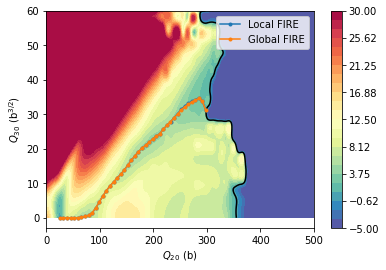

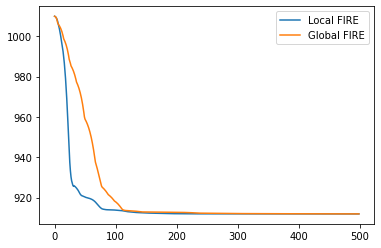

In [5]:
fIn = "..//..//PES/232U.h5"
dsets, attrs = read_from_h5(fIn)

coordStrs = ["Q20","Q30"]

uniqueCoords = [np.unique(dsets[key]) for key in coordStrs]

gridShape = [len(np.unique(dsets[key])) for key in coordStrs]

coordMesh = tuple([dsets[key].reshape(gridShape) for key in coordStrs])
zz = dsets["PES"].reshape(gridShape)

#potential = py_neb.auxiliary_potential(py_neb.NDInterpWithBoundary(uniqueCoords,zz),\
#                                 shift=0.5)
potential = py_neb.auxiliary_potential(py_neb.RectBivariateSplineWrapper(*uniqueCoords,zz).function)

#Finding initial path
gsLoc = np.array([attrs["Ground_State"][key] for key in coordStrs]).flatten()
eGS = potential(gsLoc)

# Start and endpoints can be shuffled around here

#eGS=0.0
#gsLoc=np.zeros(2)
#gsLoc[0]=25.0
#gsLoc[1]=0.0
nPts = 42
initPath = np.array((np.linspace(gsLoc[0],300,nPts),\
                     np.linspace(gsLoc[1],32,nPts))).T
#print(initPath)
f, a = standard_pes(*coordMesh,zz)
a.contour(*coordMesh,zz,levels=[eGS],colors=["black"])

# One can define local functions here when instantiating the class
lap = py_neb.LeastActionPath(potential,nPts,2,\
                             target_func_grad=py_neb.discrete_action_grad,\
                             #target_func=localAction,\
                             nebParams={"k":10,"kappa":10,"constraintEneg":1},\
                             endpointSpringForce=(False,True),\
                             endpointHarmonicForce=(False,True))
'''
lap = py_neb.LeastActionPath(potential,nPts,2,\
                             nebParams={"k":1,"kappa":1},\
                             endpointSpringForce=(False,True),\
                             endpointHarmonicForce=(False,True))
'''
maxIters = 500
tStep = 0.1

minObj = py_neb.VerletMinimization(lap,initPath)
tStepArr, alphaArr, _ = minObj.fire(tStep,maxIters,useLocal=True)

minObj2 = py_neb.VerletMinimization(lap,initPath)
tStepArr, alphaArr, _ = minObj2.fire(tStep,maxIters)

# allPts, allVelocities, allForces = \
#     minObj.velocity_verlet(tStep,maxIters)
a.plot(minObj.allPts[-1,:,0],minObj.allPts[-1,:,1],marker=".",label="Local FIRE")
a.plot(minObj2.allPts[-1,:,0],minObj2.allPts[-1,:,1],marker=".",label="Global FIRE")
a.legend()
# print("Slow interpolator time: "+str(t1 - t0))
# print("Slow interpolator action: "+str(actions[-1]))

actions = np.array([py_neb.action(minObj.allPts[i],potential)[0] for i in range(maxIters)])
actions2 = np.array([py_neb.action(minObj2.allPts[i],potential)[0] for i in range(maxIters)])
# print(actions)
actionFig, actionAx = plt.subplots()
actionAx.plot(actions,label="Local FIRE")
actionAx.plot(actions2,label="Global FIRE")

actionAx.legend()

#print(potential(minObj.allPts[-1]))
print("Final Local: ",actions[-1])
print("Final Global: ",actions2[-1])